In [1]:
import numpy as np
import scipy as sp

In [2]:
from matplotlib import pyplot as plt
import skimage
from skimage import (morphology, segmentation, exposure, feature, filters,
                     measure, transform, util, io, color)

In [3]:
from toolz.curried import *

In [33]:
from spotz import imgz, gridder2, segmenter2, spotzplot

In [34]:
from importlib import reload

In [80]:
reload(imgz)
reload(gridder2)
reload(spotzplot)
reload(segmenter2)

<module 'segmenter2' from '/Users/pmagwene/gits/spotz/segmenter2.py'>

In [81]:
%matplotlib inline

# User settings

In [82]:
# change name of file
PLATE_IMG = "test/example-easy-plate.tiff"
OUTPUT_FILE = "test_output.csv"

# change number of rows and cols as appropriate
NROWS = 8
NCOLS = 12

# change if you'd like larger or smaller figs
FIG_SIZE = (10,8)

# Original image

In [83]:
img = imgz.read_image(PLATE_IMG)

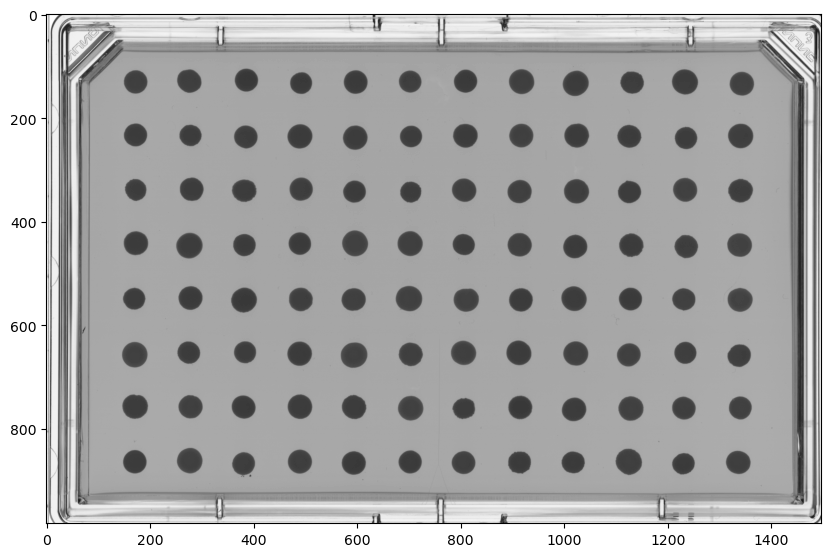

In [84]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(img)

# Invert image

In [85]:
iimg = imgz.invert(img)

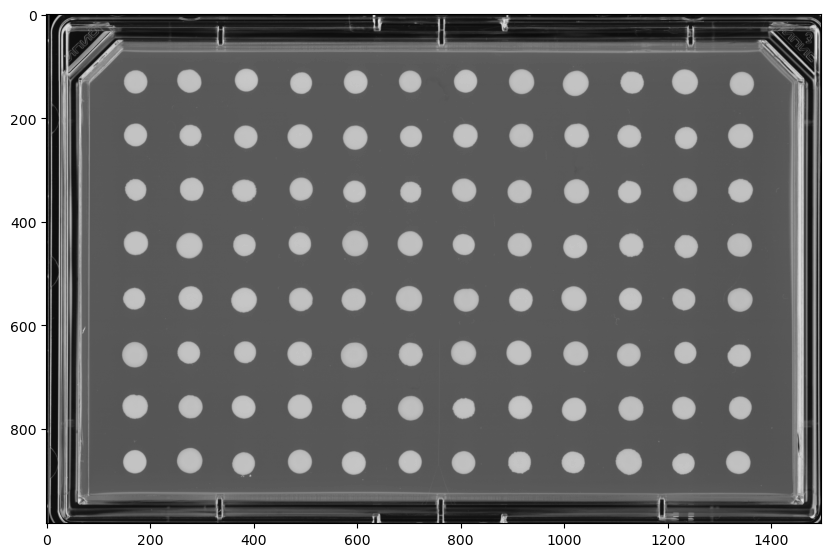

In [86]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(iimg)
pass

# Gridding

## Thresholding and binary opening

In [87]:
# initial thresholding and rotation correction
rbimg = pipe(iimg, 
             imgz.threshold_otsu,
             imgz.disk_opening(3), 
             imgz.clear_border, 
             gridder2.fix_rotation)


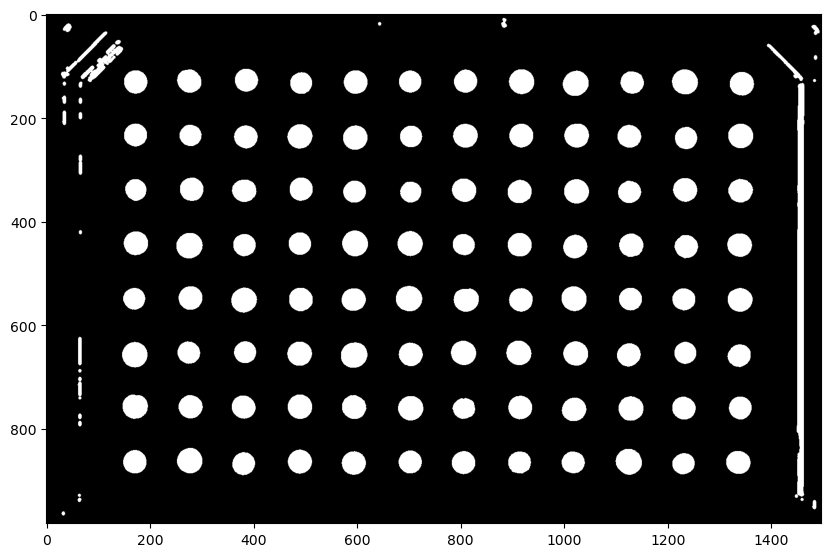

In [88]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(rbimg)
pass

## Estimate grid coordinates and draw grid

In [89]:
g = gridder2.find_grid(NROWS, NCOLS, rbimg)

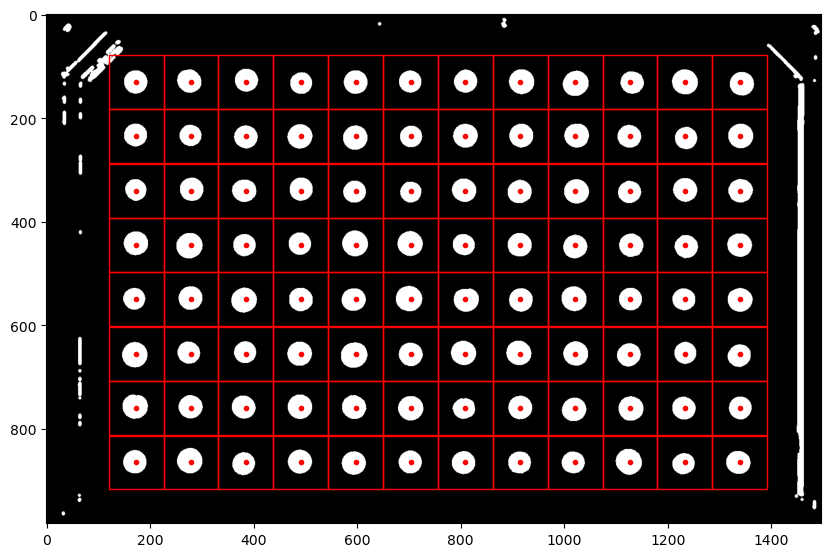

In [90]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(rbimg)
ax = plt.gca()
ax.plot(g.centers[:,1], g.centers[:,0], 'r.')
spotzplot.draw_bboxes(g.bboxes, ax)
pass

# Segmentation

## Rethreshold based on grid

In [91]:
timg = pipe(iimg,
            segmenter2.threshold_bboxes(g.bboxes),
            imgz.remove_small_objects(50),
            imgz.remove_small_holes(25),
            imgz.disk_closing(3),
            imgz.clear_border)

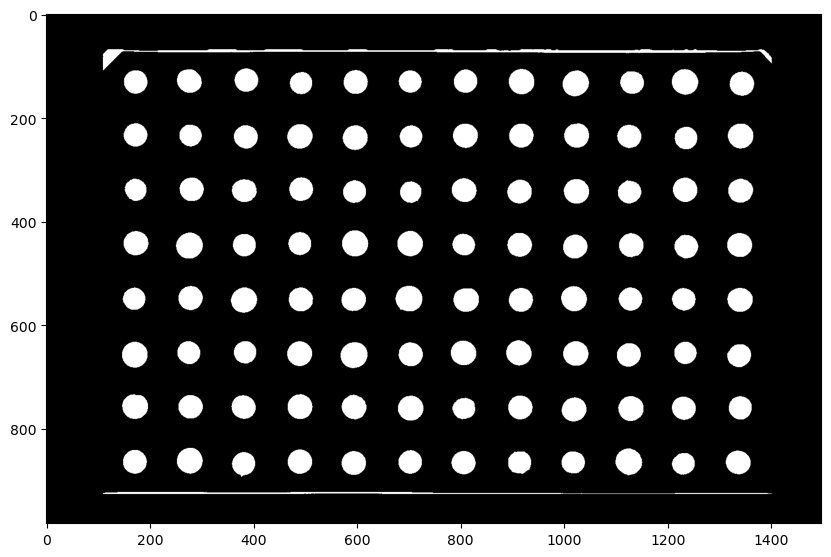

In [92]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(timg)
pass

## Segmentation by watershed

### Filter objects by grid

In [93]:
filtered_img, filtered_regions = segmenter2.assign_objects_to_grid(g.centers, 
                                                                   timg, 
                                                                   maxdist = 30) 
filtered_bboxes = [r.bbox if r else None for r in filtered_regions]



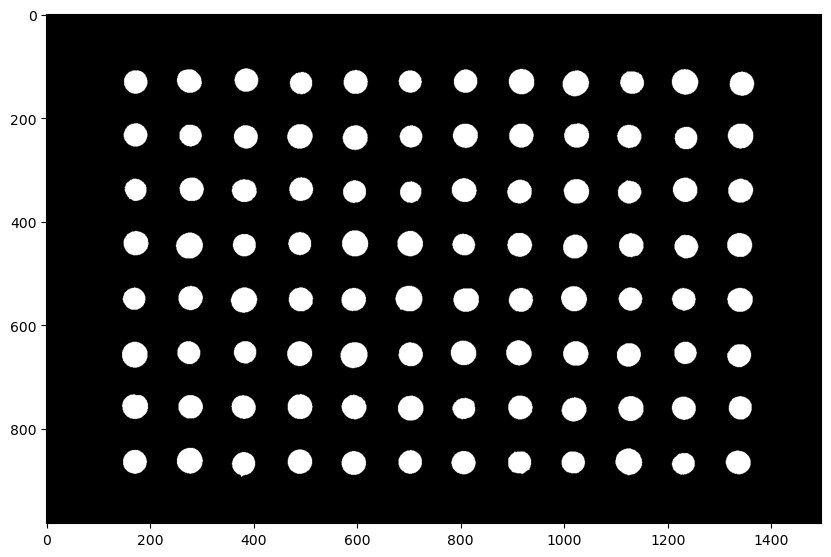

In [94]:
fig = plt.figure(figsize = FIG_SIZE)
imgz.imshowg(filtered_img > 0)
pass

In [95]:
wshed = segmenter2.watershed_segment_bboxes(g.centers, 
                                             filtered_bboxes, 
                                             iimg, timg, 
                                             seed_width = 5)

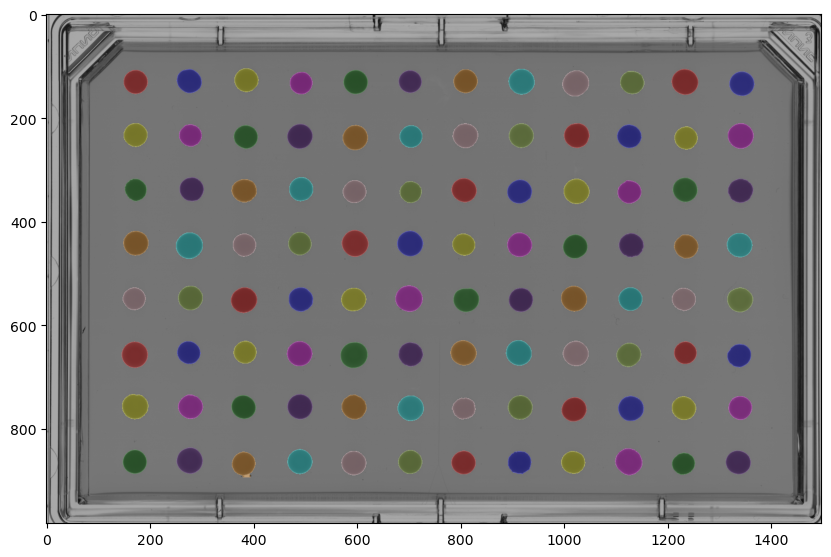

In [96]:
fig = plt.figure(figsize = FIG_SIZE)
ax = plt.gca()
ax.imshow(color.label2rgb(wshed, img, bg_label = 0))
pass

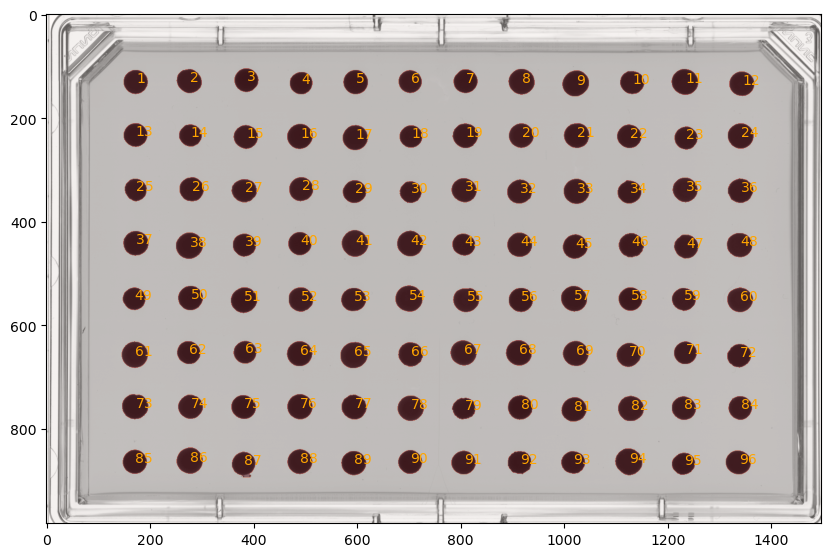

In [97]:
fig, ax = spotzplot.draw_image_and_labels(img, wshed,
                                          mask_cmap = "Reds", alpha = 0.35,
                                         fontsize = 10, textcolor = "orange")
fig.set_size_inches(FIG_SIZE)

In [98]:
import spotstats

In [99]:
regions = measure.regionprops(wshed, intensity_image = filtered_img)

In [100]:
colonydf = spotstats.colony_stats(regions, 8, 12)
colonydf

,label,row,col,centroid_r,centroid_c,area,perimeter,major_axis_length,minor_axis_length,eccentricity,equiv_diameter,mean_intensity,solidity,convex_area,bbox_minr,bbox_minc,bbox_maxr,bbox_maxc
0,1,1.000000,1.0,130.635677,172.793144,1721.0,152.367532,46.983503,46.643244,0.120132,46.810739,0.938989,0.979511,1757.0,108,150,155,197
1,2,1.083333,1.0,128.971154,276.255090,1768.0,154.610173,49.551839,45.445354,0.398594,47.445627,1.928733,0.979501,1805.0,106,252,153,301
2,3,1.166667,1.0,127.209928,386.589713,1672.0,149.781746,46.487071,45.802819,0.170944,46.139533,2.897727,0.980645,1705.0,105,364,151,411
3,4,1.250000,1.0,132.966777,492.371429,1505.0,141.882251,44.214624,43.343802,0.197491,43.774713,3.837874,0.981735,1533.0,112,471,155,515
4,5,1.333333,1.0,130.998301,597.748584,1766.0,154.367532,47.724621,47.113838,0.159475,47.418784,4.790487,0.980566,1801.0,108,574,155,622
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,92,8.583333,1.0,865.528900,914.305780,1609.0,148.710678,46.099858,44.479041,0.262834,45.261931,88.169049,0.971618,1656.0,844,892,889,938
92,93,8.666667,1.0,865.488722,1017.867168,1596.0,147.539105,46.531781,43.682986,0.344524,45.078712,88.454887,0.976744,1634.0,844,995,888,1042
93,94,8.750000,1.0,864.161290,1125.389469,2108.0,169.095454,53.093734,50.576371,0.304268,51.807229,90.566414,0.981378,2148.0,839,1099,891,1152
94,95,8.833333,1.0,867.989319,1231.048732,1498.0,141.539105,45.237603,42.182799,0.361242,43.672793,91.004673,0.981009,1527.0,847,1209,890,1254


In [101]:
colonydf.to_csv(OUTPUT_FILE, index=False)
print("file saved as", OUTPUT_FILE)

file saved as test_output.csv
